In [2]:
#importing required libraries
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import pydicom
from tqdm import tqdm
import glob as glob
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



from scipy.stats import norm
import scipy.ndimage as ndi
from sklearn.linear_model import LogisticRegression
from PIL import Image

In [3]:
#loading train and test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [29]:
train_data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [6]:
train_data['Patient'].value_counts()

ID00105637202208831864134    10
ID00119637202215426335765    10
ID00229637202260254240583    10
ID00140637202231728595149    10
ID00388637202301028491611    10
                             ..
ID00052637202186188008618     7
ID00344637202287684217717     7
ID00186637202242472088675     7
ID00267637202270790561585     6
ID00047637202184938901501     6
Name: Patient, Length: 176, dtype: int64

In [5]:
test_data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [6]:
print('Shape of Training data->', train_data.shape)
print('Shape of Test data->', test_data.shape)

Shape of Training data-> (1549, 7)
Shape of Test data-> (5, 7)


In [7]:
train_data.describe()

,Weeks,FVC,Percent,Age
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509
std,23.247550,832.770959,19.823261,7.057395
min,-5.000000,827.000000,28.877577,49.000000
25%,12.000000,2109.000000,62.832700,63.000000
50%,28.000000,2641.000000,75.676937,68.000000
75%,47.000000,3171.000000,88.621065,72.000000
max,133.000000,6399.000000,153.145378,88.000000


In [8]:
test_data.describe()

,Weeks,FVC,Percent,Age
count,5.000000,5.000000,5.000000,5.000000
mean,8.800000,2781.600000,75.997702,71.800000
std,7.049823,516.475846,4.970960,2.167948
min,0.000000,1930.000000,70.186855,68.000000
25%,6.000000,2739.000000,71.824968,72.000000
50%,6.000000,2925.000000,76.672493,73.000000
75%,15.000000,3020.000000,79.258903,73.000000
max,17.000000,3294.000000,82.045291,73.000000


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   Age            5 non-null      int64  
 5   Sex            5 non-null      object 
 6   SmokingStatus  5 non-null      object 
dtypes: float64(1), int64(3), object(3)
memory usage: 408.0+ bytes


In [11]:
train_data.duplicated().sum()

0

In [12]:
test_data.duplicated().sum()

0

In [13]:
print("Number of patients unique ids's in train_data->", train_data['Patient'].nunique())
print("Number of patients unique ids's in test_data->", test_data['Patient'].nunique())

Number of patients unique ids's in train_data-> 176
Number of patients unique ids's in test_data-> 5


In [14]:
train_data['SmokingStatus'].value_counts()


Ex-smoker           1038
Never smoked         429
Currently smokes      82
Name: SmokingStatus, dtype: int64

<AxesSubplot: xlabel='SmokingStatus', ylabel='count'>

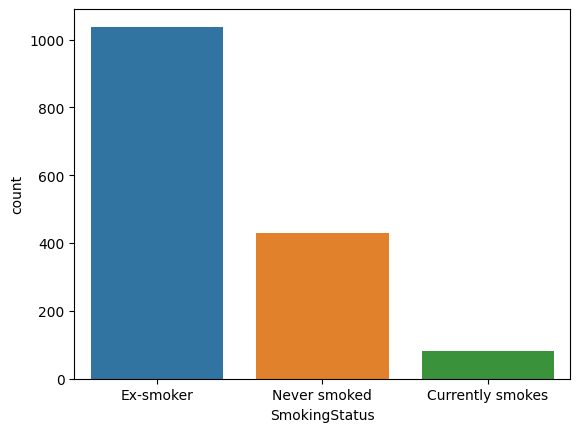

In [15]:
sns.countplot(x = train_data["SmokingStatus"])

In [16]:
new = train_data.groupby([train_data.Patient,train_data.Age, train_data.Sex, train_data.SmokingStatus])['Patient'].count()
new.index = new.index.set_names(['id','Age','Sex','SmokingStatus'])
new = new.reset_index()
new.rename(columns = {'Patient':'freq'},inplace =True)
new.head(10)

,id,Age,Sex,SmokingStatus,freq
0,ID00007637202177411956430,79,Male,Ex-smoker,9
1,ID00009637202177434476278,69,Male,Ex-smoker,9
2,ID00010637202177584971671,60,Male,Ex-smoker,9
3,ID00011637202177653955184,72,Male,Ex-smoker,9
4,ID00012637202177665765362,65,Male,Never smoked,9
5,ID00014637202177757139317,56,Male,Ex-smoker,9
6,ID00015637202177877247924,71,Male,Ex-smoker,8
7,ID00019637202178323708467,83,Female,Ex-smoker,9
8,ID00020637202178344345685,66,Female,Never smoked,9
9,ID00023637202179104603099,71,Female,Ex-smoker,9


In [17]:
new.freq.max()

10

<AxesSubplot: xlabel='SmokingStatus', ylabel='count'>

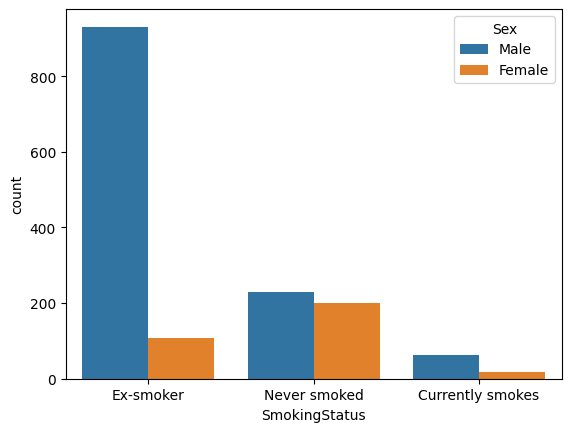

In [16]:
sns.countplot(x = train_data['SmokingStatus'], hue = train_data['Sex'])

## age_count = new['Age'].value_counts().to_frame(name='count')
age_count

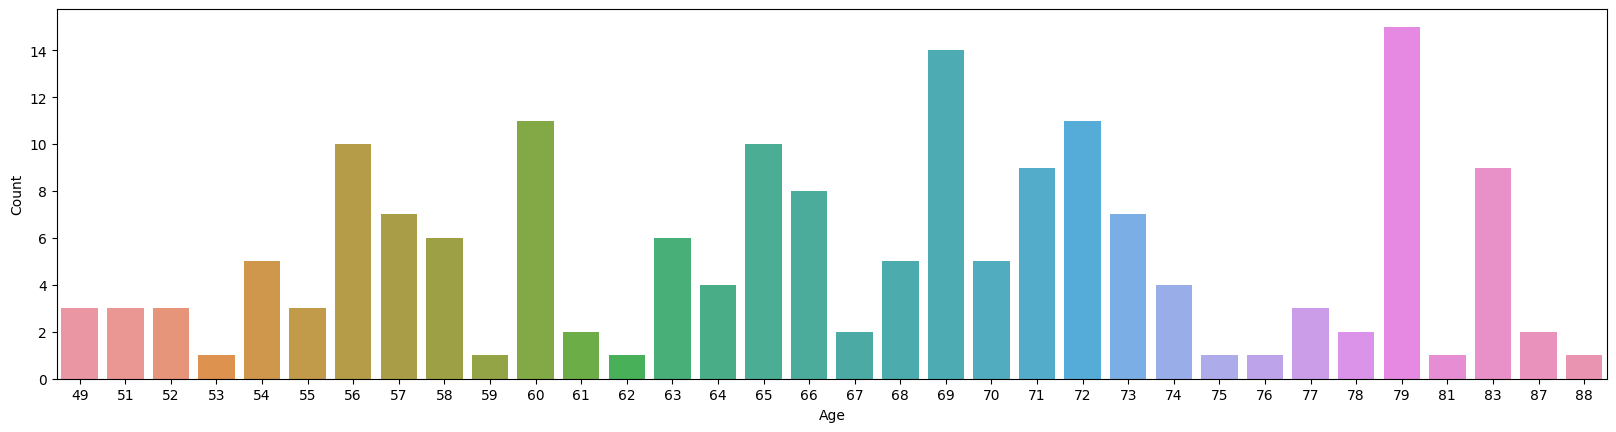

In [17]:
x = new['Age'].unique()
y = new['Age'].value_counts()
plt.figure().set_figwidth(20)
sns.barplot(x=x,y=y)
plt.xlabel('Age')

plt.ylabel('Count')
plt.show()

<AxesSubplot: xlabel='FVC', ylabel='Age'>

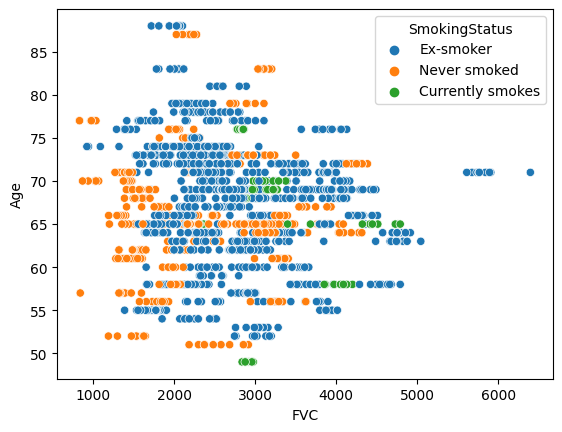

In [18]:
sns.scatterplot(train_data, x= 'FVC', y = 'Age', hue = 'SmokingStatus')

In [19]:
img = 'E:/CDAC-Project/train/ID00007637202177411956430/10.dcm'

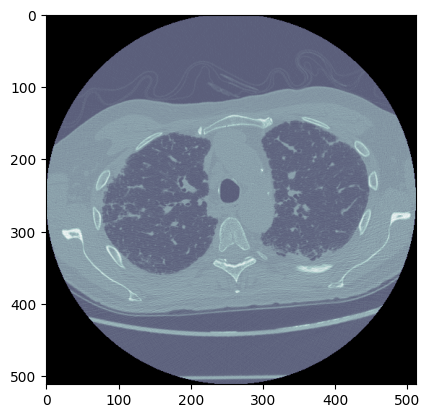

In [20]:
ds = pydicom.dcmread(img)
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)

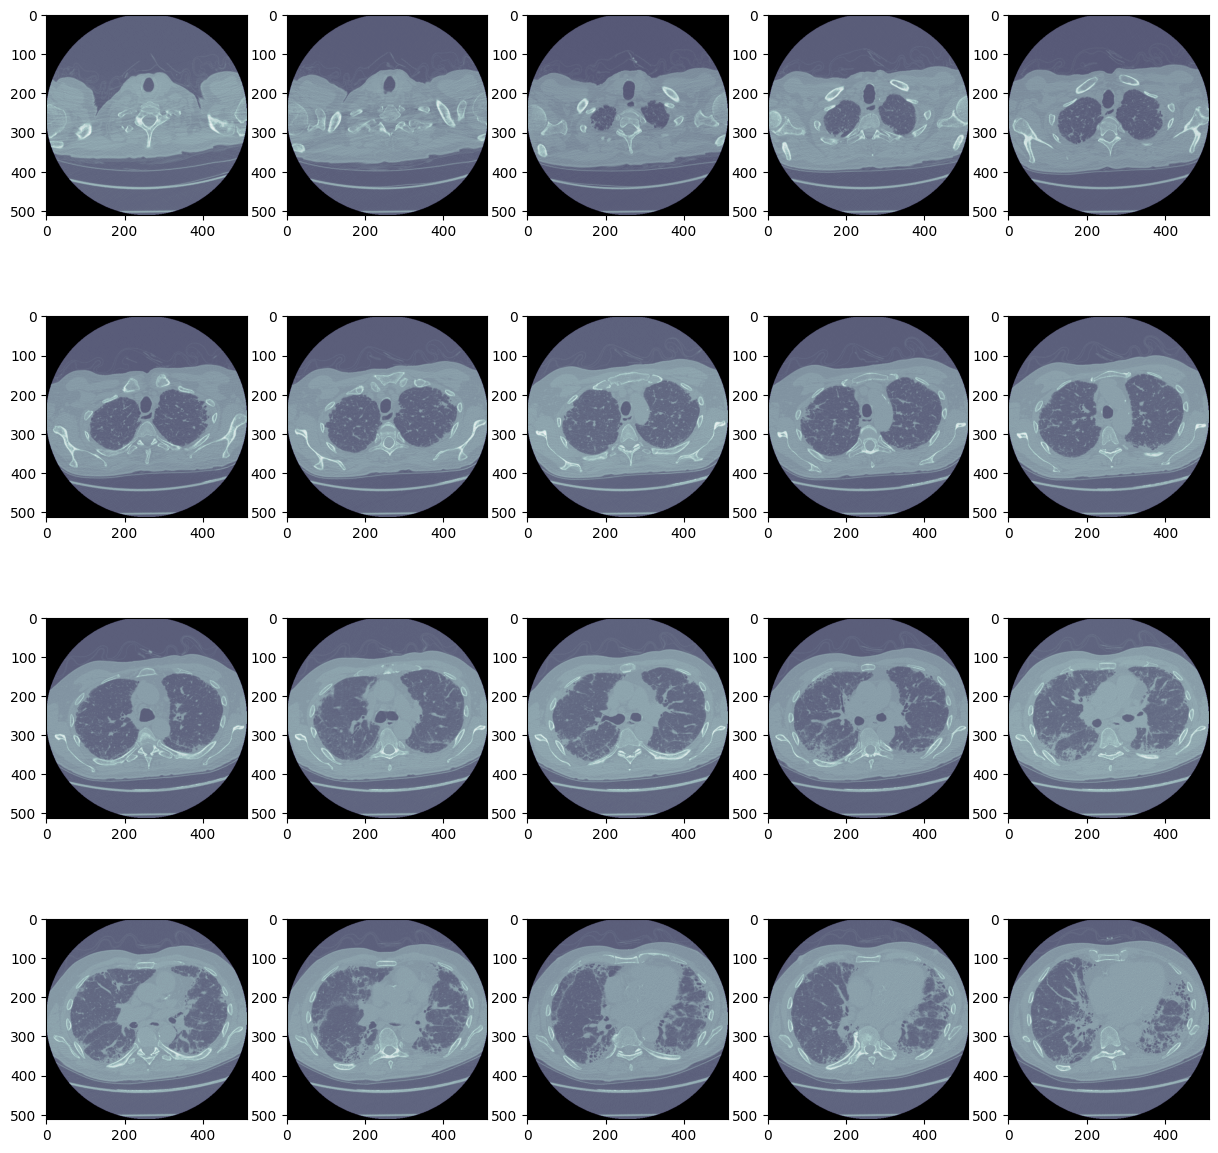

In [21]:
img_dir = 'E:/CDAC-Project/train/ID00007637202177411956430'
fig = plt.figure(figsize=(15,15))
img_list = os.listdir(img_dir)
for i in range(1,21):
    file_name = img_dir + "/" + str(i) + ".dcm"
    DS = pydicom.dcmread(file_name)
    fig.add_subplot(4,5,i)
    plt.imshow(DS.pixel_array,cmap=plt.cm.bone)